## Neural Net for combined Copy Number Variation and RNAseq

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

### Import and Process Data

In [3]:
working_directory = '/Users/a.su/Documents/MultiClassCancer_RNAseq_CNV_lncRNA/'

#Import Data
y = pd.read_table(working_directory + 'CancerTypes_y_BinaryClass.txt', sep = '\t', header = None)
x_cnv = pd.read_table(working_directory + 'CNV_processed_multiClass.txt', sep = '\t', header = 0)
x_rna = pd.read_table(working_directory + 'RNAseq_processed_multiClass.txt', sep = '\t', header = 0)
x_lnc = pd.read_table(working_directory + 'lncRNA_processed_multiClass.txt', sep = '\t', header = 0)

/Users/a.su/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Remove GeneID Column
x_cnv = x_cnv.drop('GeneID', axis = 1)
x_rna = x_rna.drop('GeneID', axis = 1)
x_lnc = x_lnc.drop('GeneID', axis = 1)

# Transpose
x_cnv = x_cnv.transpose()
x_rna = x_rna.transpose()
x_lnc = x_lnc.transpose()
print('x_cnv shape is:{0}  x_rna shape is:{1}  x_lnc shape is:{2}'.format(x_cnv.shape, x_rna.shape, x_lnc.shape))
print('y shape is:', y.shape)

x_cnv shape is:(668, 26374)  x_rna shape is:(668, 26094)  x_lnc shape is:(668, 21770)
y shape is: (668, 1)


In [14]:
drop_threshold = 0.5*len(x_cnv.index)

#DropNa from columns with at least 50% NaN
x_cnv_dropped = x_cnv.dropna(thresh = drop_threshold)
x_rna_dropped = x_rna.dropna(thresh = drop_threshold)
x_lnc_dropped = x_lnc.dropna(thresh = drop_threshold)

#Columns dropped
def print_dropped_columns(df, df_dropped, df_name):
    print('Dropped {0} Columns from {1}'.format(len(df.columns) - len(df_dropped.columns), df_name))

print_dropped_columns(x_cnv, x_cnv_dropped, 'x_cnv')
print_dropped_columns(x_rna, x_rna_dropped, 'x_rna')
print_dropped_columns(x_lnc, x_lnc_dropped, 'x_lnc')

Dropped 0 Columns from x_cnv
Dropped 0 Columns from x_rna
Dropped 0 Columns from x_lnc


In [16]:
#Impute 
impute_median = SimpleImputer(strategy = 'median')
x_cnv_imputed = pd.DataFrame(impute_median.fit_transform(x_cnv_dropped))
x_rna_imputed = pd.DataFrame(impute_median.fit_transform(x_rna_dropped))
x_lnc_imputed = pd.DataFrame(impute_median.fit_transform(x_lnc_dropped))

#Check for NaN values
print(np.isnan(x_cnv_imputed).all().any())
print(np.isnan(x_rna_imputed).all().any())
print(np.isnan(x_lnc_imputed).all().any())

False
False
False


In [17]:
def count_all_zeros (df, _axis_ = 0):
    return len(df.columns) - np.count_nonzero(df.sum(axis = _axis_), axis = _axis_)

#Count number of columns with all zeros
print('CNV: {0}  RNA: {1}  lnc: {2}'.format(count_all_zeros(x_cnv_imputed, 0), count_all_zeros(x_rna_imputed, 0), count_all_zeros(x_lnc_imputed, 0)))

CNV: 0  RNA: 111  lnc: 374


In [19]:
#Delete columns with all zeros
x_cnv_nozero = x_cnv_imputed.loc[:, (x_cnv_imputed != 0).any(axis = 0)]
x_rna_nozero = x_rna_imputed.loc[:, (x_rna_imputed != 0).any(axis = 0)]
x_lnc_nozero = x_lnc_imputed.loc[:, (x_lnc_imputed != 0).any(axis = 0)]

#Count number of column deletions
print_dropped_columns(x_cnv_imputed, x_cnv_nozero, 'x_cnv_imputed')
print_dropped_columns(x_rna_imputed, x_rna_nozero, 'x_rna_imputed')
print_dropped_columns(x_lnc_imputed, x_lnc_nozero, 'x_lnc_imputed')

Dropped 0 Columns from x_cnv_imputed
Dropped 111 Columns from x_rna_imputed
Dropped 374 Columns from x_lnc_imputed


In [20]:
#Count number of columns with all zeros
print('CNV: {0}  RNA: {1}  lnc: {2}'.format(count_all_zeros(x_cnv_nozero, 0), count_all_zeros(x_rna_nozero, 0), count_all_zeros(x_lnc_nozero, 0)))

CNV: 0  RNA: 0  lnc: 0


In [21]:
#Scale data
zscore = lambda x: (x-x.mean())/ x.std()

x_rna_processed, x_cnv_processed, x_lnc_processed = x_rna_nozero.transform(zscore), x_cnv_nozero.transform(zscore), x_lnc_nozero.transform(zscore)

In [22]:
#Visualise
x_rna_processed[np.random.choice(x_rna_processed.columns.values, size = 10, replace = False)].describe()

,12487,5753,737,2562,11425,16547,24854,5455,12350,8147
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-1.146372e-16,-2.020922e-15,-1.022136e-16,-2.336787e-16,-3.639803e-17,-4.022065e-17,1.632094e-15,1.921284e-16,1.775858e-16,1.158837e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.175896e-01,-2.253205e+00,-4.516296e-01,-1.306047e-01,-9.214165e-01,-1.280161e-01,-1.615719e+00,-1.532818e+00,-2.207011e-01,-1.199498e-01
25%,-1.175896e-01,-6.991449e-01,-4.228890e-01,-1.306047e-01,-6.907236e-01,-1.280161e-01,-7.215327e-01,-6.348967e-01,-2.207011e-01,-1.199498e-01
50%,-1.170479e-01,-1.609660e-01,-3.319321e-01,-1.306047e-01,-2.887956e-01,-1.280161e-01,-1.966727e-01,-2.596224e-01,-2.157832e-01,-1.199498e-01
75%,-1.152061e-01,4.947073e-01,-6.101122e-02,-1.306047e-01,3.889205e-01,-1.280161e-01,5.069440e-01,3.182714e-01,-1.780904e-01,-1.199498e-01
max,1.454763e+01,5.083234e+00,8.410616e+00,1.693135e+01,7.634497e+00,1.558349e+01,5.687175e+00,7.220549e+00,1.532383e+01,1.391301e+01


In [23]:
x_cnv_processed[np.random.choice(x_cnv_processed.columns.values, size = 10, replace = False)].describe()

,13695,25968,19962,7004,10605,6490,14862,19744,14019,6087
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-2.588581e-17,-1.656360e-15,-6.184341e-16,7.312846e-18,-2.403267e-16,-7.494005e-16,-6.823040e-17,1.898743e-16,2.084784e-17,-2.719049e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.978819e+00,-1.704757e+00,-2.869904e+00,-3.162434e+00,-2.457613e+00,-2.908864e+00,-2.699246e+00,-2.884606e+00,-4.951408e+00,-3.551228e+00
25%,-6.330090e-01,-7.239446e-01,-6.233354e-01,-6.338787e-01,-6.977157e-01,-7.220836e-01,-5.526348e-01,-6.278553e-01,-5.513666e-01,-7.089720e-01
50%,2.456771e-02,-3.020573e-01,1.130505e-01,6.765887e-02,4.018717e-02,5.263328e-02,-5.919822e-02,-8.798074e-02,-4.421750e-02,6.359116e-02
75%,5.339578e-01,4.548008e-01,5.442690e-01,5.874970e-01,5.885094e-01,6.167617e-01,4.980750e-01,5.204380e-01,6.110172e-01,5.716685e-01
max,3.721310e+00,3.715229e+00,3.297282e+00,4.122432e+00,4.695112e+00,3.694351e+00,6.899406e+00,4.414637e+00,4.733596e+00,3.989150e+00


In [25]:
x_lnc_processed[np.random.choice(x_lnc_processed.columns.values, size = 10, replace = False)].describe()

,12251,19330,12469,7594,369,11436,12334,10454,7681,13440
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-1.755914e-16,1.012580e-16,-2.660463e-16,1.350384e-16,1.217838e-16,7.479047e-17,-9.805862e-17,3.543199e-16,4.861381e-17,-1.554811e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.385407e-01,-1.808313e-01,-9.698979e-02,-1.536308e-01,-7.882057e-02,-1.310467e-01,-4.127368e-01,-1.116901e-01,-5.192552e-01,-3.095011e-01
25%,-2.385407e-01,-1.808313e-01,-9.698979e-02,-1.536308e-01,-7.882057e-02,-1.310467e-01,-4.127368e-01,-1.116901e-01,-5.192552e-01,-2.899122e-01
50%,-2.385407e-01,-1.808313e-01,-9.698979e-02,-1.536308e-01,-6.616444e-02,-1.310467e-01,-4.127368e-01,-1.116901e-01,-5.192552e-01,-1.757135e-01
75%,-1.519434e-01,-1.532500e-01,-9.698979e-02,-1.536308e-01,-3.830674e-02,-1.310467e-01,-4.127368e-01,-1.116901e-01,2.638535e-01,5.233353e-02
max,2.026006e+01,1.715192e+01,1.496688e+01,2.281376e+01,2.564887e+01,2.006303e+01,7.389143e+00,1.801424e+01,1.132087e+01,1.892238e+01


In [27]:
#Check for NaN values
print('CNV: {0}  RNA: {1}  lnc: {2}'.format(
    x_cnv_processed.isnull().any().any(), x_rna_processed.isnull().any().any(), x_lnc_processed.isnull().any().any()))

CNV: False  RNA: False  lnc: False


In [12]:
#Combine CNV and RNA data
x_combined = pd.concat([x_cnv_processed.reset_index(drop = True), x_rna_processed.reset_index(drop = True)] , axis = 1)
y_combined = y
x_combined.shape

(668, 52077)

### Neural Net

In [13]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [14]:
#Split data into training and test sets
x_combined_train, x_combined_test, y_combined_train, y_combined_test = train_test_split(
    x_combined, y_combined.values.flatten(), test_size = 0.25, random_state = 0)

In [30]:
"""
Best settings so far are:

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

Accuracy ~81.4%

model.add(Dense(16, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(16, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

Accuracy ~82% with 150 epochs
"""

model = Sequential()
#model.add(Dense(16, activation = 'relu'))
#model.add(Dropout(0.3))
#model.add(Dense(16, activation = 'relu'))
#model.add(Dropout(0.3))
#model.add(Dense(32, activation = 'relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation = 'linear'))

In [31]:
model.compile(loss = 'hinge', optimizer = 'adam', metrics = ['accuracy'])

In [32]:
model.fit(x_combined_train.values, y_combined_train, epochs = 500, batch_size = 32, verbose = 1)

Epoch 1/500
501/501 [==============================] - 1s 2ms/step - loss: 1.1248 - acc: 0.0259
Epoch 2/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7629 - acc: 0.0180
Epoch 3/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7395 - acc: 0.0120
Epoch 4/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.0100
Epoch 5/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.0060
Epoch 6/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.0080
Epoch 7/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.0080
Epoch 8/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.0080
Epoch 9/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.0080
Epoch 10/500
501/501 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.0080
Epoch 11/500
501/501 [=================

In [33]:
model.evaluate(x_combined_test, y_combined_test)

167/167 [==============================] - 0s 1ms/step


[1.3102666467963577, 0.0]

In [19]:
model.metrics_names

['loss', 'acc']

In [28]:
import matplotlib.pyplot as plt

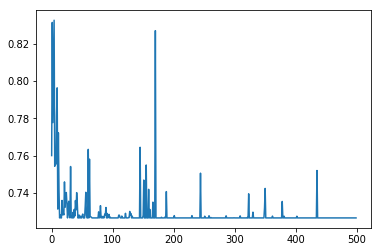

In [29]:
plt.plot(model.history.epoch, model.history.history['loss'])
plt.show()